In [1188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1189]:
def f(x):
    return 3*x**2 - 4 * x + 5

In [1190]:
f(3.0)

20.0

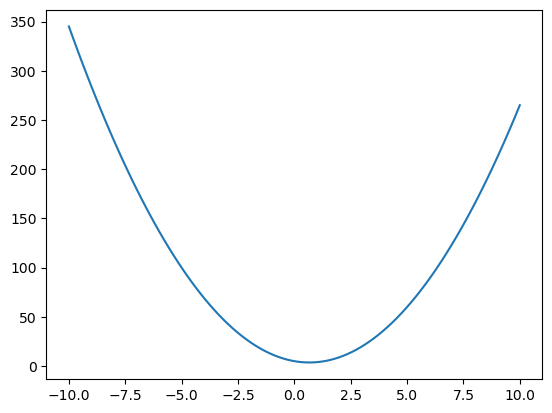

In [1191]:
x = np.linspace(-10, 10, 100)
y = [f(x_i) for x_i in x]

plt.plot(x, y)

In [1192]:
h = 0.000001
x = 22
df = (f(x + h) - f(x)) / h
df

128.0000030874362

In [1193]:
h = 0.0001

a = 2 
b = -3
c = 10

d1 = a * b + c
a += h
d2 = a * b + c

print('d1: ', d1)
print('d2: ', d2)

print('slope: ', (d2 - d1)/h)
# essentially trying to find the slope of line (b)

d1:  4
d2:  3.999699999999999
slope:  -3.000000000010772


In [1204]:
# building a backpropagation network

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, ex '+', '*', '/', etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (np.exp(2 * x) - 1)/(np.exp(2 * x) + 1)
        output = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * output.grad
        
        output._backward = _backward
        return output

    def exp(self):
        x = self.data
        output = Value(np.exp(x), (self,), 'exp')

        def _backward():
            self.grad += np.exp(x) * output.grad

        output._backward = _backward
        return output

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [1205]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
 
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect ni to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [1206]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [1207]:
o.backward()

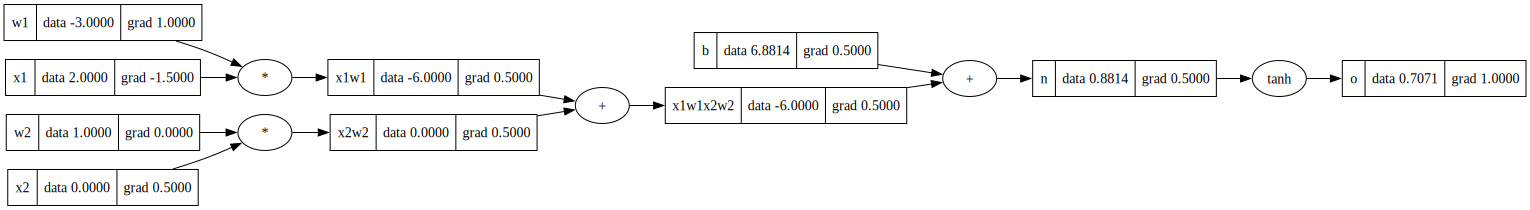

In [1208]:
draw_dot(o)

In [1209]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2';
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'o'

In [1211]:
o.backward()

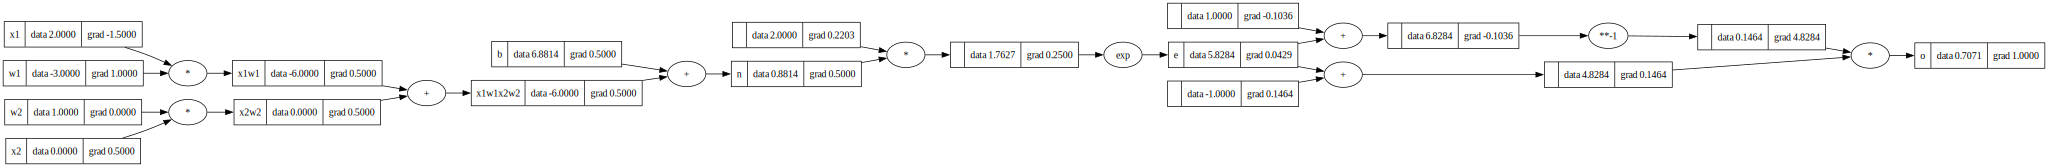

In [1212]:
draw_dot(o)

In [1213]:
import torch

In [1214]:
x1 = torch.Tensor([2.0]) ; x1.requires_grad = True
x2 = torch.Tensor([0.0]) ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]) ; w1.requires_grad = True
w2 = torch.Tensor([1.0]) ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]) ; b.requires_grad = True

n = x1 * w1 + x2 * w2 + b 
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071067094802856
---
x2 0.5000001192092896
w2 0.0
x1 -1.5000003576278687
w1 1.000000238418579


In [1215]:
import random

In [1488]:

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [1489]:
x = np.array([2.0, 3.0, -1.0])
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5331011845399515, grad=0)

In [1490]:
xs = np.array([
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
])

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

In [1491]:
# Initial
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.7423167429600355, grad=0)

In [1588]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=8.344621341838916e-05, grad=0)

In [1589]:
loss.backward()

In [1590]:
for p in n.parameters():
    p.data -= 0.01 * p.grad

In [1591]:
ypred

[Value(data=0.9942536343733706, grad=-0.011492731253258892),
 Value(data=-0.9999096740744402, grad=0.00018065185111959536),
 Value(data=-0.9991811226091637, grad=0.0016377547816726068),
 Value(data=0.992946860518221, grad=-0.014106278963557983)]

In [1619]:
for k in range(10):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # zero grad the parameters (so we have accurate gradients)
    for p in n.parameters():
        p.data = 0

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data -= 0.05 * p.grad

In [1620]:
loss

Value(data=0.029048484306767042, grad=1)

In [1621]:
ypred

[Value(data=0.9437420516890973, grad=-0.11251589662180539),
 Value(data=-0.8980797545628747, grad=0.2038404908742506),
 Value(data=-0.9174093540423449, grad=0.16518129191531017),
 Value(data=0.9068625943621562, grad=-0.18627481127568757)]

In [ ]:
8